In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Utils to be used in TDControl
class Utils:
    def __init__(self, days, spread):
        self.days = days
        self.spread = spread
        self.data = self.constructData()
        
    # Simulate the up and down of stock by random (50% up by spread amound and 50% down by spread amount)
    def constructData(self):
        data = [100]
        for i in range(self.days):
            isUp = np.random.rand() >= 0.5
            if isUp:
                data.append(data[-1] * (1 + self.spread))
            else:
                data.append(data[-1] / (1 + self.spread))
        return data

    # Construct the empty Q-value table
    def constructQValue(self):
        return np.zeros((self.days+1, 3))

    # Compute the rewards after every action
    def reward(self, days, action):
        curPrice = self.data[days]
        nextPrice = self.data[days+1]
        profit = (nextPrice - curPrice) + action * (nextPrice - curPrice) #What is the general formula
        re = -1 * abs(profit) + 10 
        #Our aim is to fully hedge the change of stock prices
        #Hence, when there is zero profit, the model should get the max reward 
        return re


# Off-Policy TD Control Algorithm class
class TDControl:
    def __init__(self, days, alpha, gamma, epsilon):
        self.actionList = [0, -0.5, -1] #three possible action, short 0, 0.5, 1
        
        self.totalDays = days
        self.alpha = alpha
        self.gamma = gamma             # generally 0.9
        self.epsilon = epsilon
        self.totalRe = []
        self.bestActpercent = []
        
        self.reset()
        
        utils = Utils(self.totalDays, 0.1)
        self.QValue = utils.constructQValue()
    
    def reset(self):
        self.utils = Utils(self.totalDays, 0.1)
        self.data = self.utils.constructData()
        self.actions = []
    
    # To find the best strategy with highest Q-value
    def strategy(self, days):
        if days < 0 or days >= self.totalDays:
            return
        values = self.QValue[days+1]
        
        stra = np.where(values == np.max(values))[0][0]
        return stra
    
    # to update the q-value of "days"
    def update(self, days):
        if days < 0 or days >= self.totalDays:
            return
        # whether to apply greed or not
        isGreedy = np.random.rand()
        if isGreedy < self.epsilon:
            stra = np.random.choice([0, 1, 2], 1)[0]
        else:
            stra = self.strategy(days)
        act = self.actionList[stra]
        self.actions.append(act)
        
        reward = self.utils.reward(days, act)
        values = self.QValue[days]
        maxV = values[stra]
        values[stra] = values[stra] + self.alpha * (reward + self.gamma * maxV - values[stra])
        return reward
    
    #to simulate the whole strategy process
    def step(self):
        sumRe = 0
        for i in range(self.totalDays):
            sumRe += self.update(i)
        self.bestActpercent.append(self.actions.count(-1) / len(self.actions) * 100)
        return sumRe
    
    # train to get the table of Q-value, return the reward to draw a graph
    def train(self, times):
        for i in range(times):
            self.reset()
            sumRe = self.step()
            self.totalRe.append(sumRe)
        return self.totalRe
        

# Show Q-Value Table

In [3]:
# Set Hyperpameter Parameters below
## -----------------------------------
times = 10000
days = 10
alpha = 0.01
gamma = 0.9
epsilon = 0.05
## -----------------------------------
TDC = TDControl(days, alpha, gamma, epsilon)
totalRe = TDC.train(times)
QValue = pd.DataFrame(TDC.QValue, columns=['short 0', 'short 0.5', 'short 1'])
print("Q-Value Table:")
QValue

Q-Value Table:


,short 0,short 0.5,short 1
0,0.797858,9.128900,99.993472
1,0.680158,8.783569,99.993620
2,0.361332,9.197628,99.993684
3,0.588684,8.739928,99.993620
4,0.587224,8.658561,99.993601
5,0.217038,7.282262,99.993741
6,0.343040,8.191761,99.993633
7,-0.002964,7.548138,99.993684
8,0.476268,7.778289,99.993026
9,1.237741,7.418909,14.621771


# Draw rewards of each round

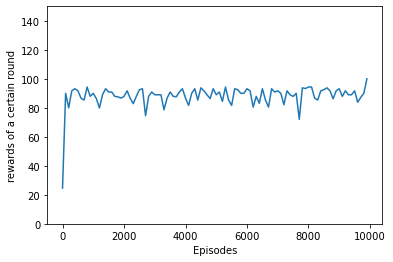

In [4]:
x1 = []
y1 = []

Print_in_Every = 100 # to print in every 100 data to make the graph more readable
for i, re in enumerate(totalRe):
    if i % Print_in_Every == 0:
        y1.append(re)
        x1.append(i)

plt.plot(x1, y1)
plt.ylim(0, 150)
plt.xlabel("Episodes")
plt.ylabel("rewards of a certain round")
plt.show()

# Draw best action percent of each round

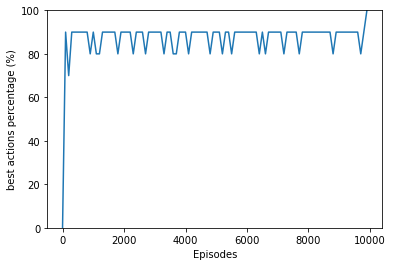

In [5]:
x2 = []
y2 = []
bestActPer = TDC.bestActpercent
# print(bestActPer)
#to print in every 100 data to make the graph more readable
Print_in_Every = 100 
for i, per in enumerate(bestActPer):
    if i % Print_in_Every == 0:
        y2.append(per)
        x2.append(i)

plt.plot(x2, y2)
plt.ylim(0, 100)
plt.xlabel("Episodes")
plt.ylabel("best actions percentage (%)")
plt.show()